In [1]:
#Importing
import re #regular expression
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib as cm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display

sns.set_theme(style='whitegrid') #seting default theme 

# Loading data

In [2]:
#imdb-sqlite on terminal
#Connect to database
con = sqlite3.connect('imdb.db')

In [3]:
#get tables list from catalog table
tables = pd.read_sql_query('SELECT NAME AS "Table_Name" FROM sqlite_master WHERE type = "table"', con)

In [4]:
tables

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes
5,ratings


In [5]:
# convert to list
tables = tables['Table_Name'].to_list()

In [6]:
for table in tables:
    consult = f'PRAGMA TABLE_INFO({table})'
    result = pd.read_sql_query(consult, con)
    print(f'Table Scheme: {table}')
    display(result)
    print('-'*100)

Table Scheme: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------
Table Scheme: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


# 1- Most famous movies categories in IMDB

In [7]:
display(pd.read_sql_query('PRAGMA TABLE_INFO(titles)', con))

,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


In [8]:
consult = 'SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'
#Creating the SQL consult to get categories

In [9]:
result = pd.read_sql_query(consult, con).sort_values('COUNT', ascending=False)
#format to a pd dataframe

In [10]:
display(result)

,type,COUNT
4,tvEpisode,6027449
3,short,828461
0,movie,586428
11,video,319884
8,tvSeries,213736
6,tvMovie,132765
5,tvMiniSeries,39532
10,tvSpecial,33945
12,videoGame,28997
9,tvShort,10247


## Visualization

In [11]:
result['percentage'] = (result['COUNT']/result['COUNT'].sum()) * 100
#Calcula percetege from all types

In [12]:
display(result.sort_values('percentage', ascending=False))

,type,COUNT,percentage
4,tvEpisode,6027449,73.313724
3,short,828461,10.076827
0,movie,586428,7.132905
11,video,319884,3.890848
8,tvSeries,213736,2.599737
6,tvMovie,132765,1.614862
5,tvMiniSeries,39532,0.480840
10,tvSpecial,33945,0.412884
12,videoGame,28997,0.352699
9,tvShort,10247,0.124637


In [13]:
#Create 4 categories to the plot
#3 firts and 1 that has all the others

others = {}

#getting all result with percentage lower than 5
others['COUNT'] = result[result['percentage'] < 5]['COUNT'].sum()

#getting the percentage
others['percentage'] = result[result['percentage'] < 5]['percentage'].sum()

#Changing name
others['type'] = 'others'

In [14]:
others

{'COUNT': 779109, 'percentage': 9.476543484376897, 'type': 'others'}

In [15]:
#get all types with more than 5%
result = result[result['percentage'] > 5]

In [16]:
#Append with 'others' dataframe
result = result.append(others, ignore_index=True)

In [17]:
display(result)

,type,COUNT,percentage
0,tvEpisode,6027449,73.313724
1,short,828461,10.076827
2,movie,586428,7.132905
3,others,779109,9.476543


In [31]:
#get labels using for
#plotData = {}
#for ind in result.index:
#    plotData[f'{result["type"][ind]}'] = round(result['percentage'][ind], 2)
#plotData

{'tvEpisode': 73.31, 'short': 10.08, 'movie': 7.13, 'others': 9.48}

In [57]:
#get labels using list comphehension
#Add a key and value to every item that will show in plot
plotData = {f'{result["type"][ind]}':round(result['percentage'][ind], 2) for ind in result.index}

plotData

{'tvEpisode': 73.31, 'short': 10.08, 'movie': 7.13, 'others': 9.48}

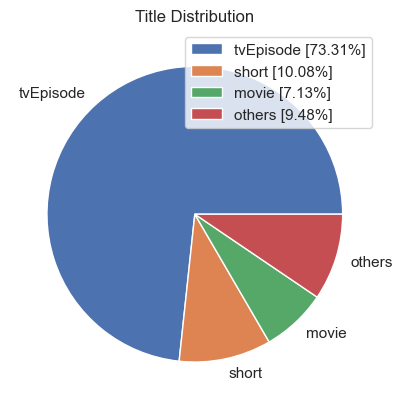

In [72]:
#Creating plot
plt.pie(x=plotData.values(), labels=plotData.keys())
plt.legend(labels= [f'{key} [{value}%]' for key, value in plotData.items()]) #Make legend, get labels with a list chomprehntion
plt.title('Title Distribution')
plt.show()
#Color style
